In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

In [139]:
# --- STEP 0: DATA LOADING ---

# Path to your file (make sure the 'data' folder exists)
file_path = "barley_yield_from_1982.csv"

# 1. Load yield data (Target variable) - Source: 'KPI to model'
df_yield = pd.read_csv(file_path, sep=';', index_col=0)

# 2. Load the climate parquet file (Features)
df_meteo = pd.read_parquet('climate_data_from_1982.parquet')

# Display the first few rows to verify the data
print(df_meteo.head())

         scenario nom_dep code_dep                time  year  \
29950  historical     Ain       01 1982-01-01 12:00:00  1982   
29951  historical     Ain       01 1982-01-02 12:00:00  1982   
29952  historical     Ain       01 1982-01-03 12:00:00  1982   
29953  historical     Ain       01 1982-01-04 12:00:00  1982   
29954  historical     Ain       01 1982-01-05 12:00:00  1982   

                             metric       value  
29950  near_surface_air_temperature  276.292267  
29951  near_surface_air_temperature  275.092407  
29952  near_surface_air_temperature  276.418518  
29953  near_surface_air_temperature  278.893372  
29954  near_surface_air_temperature  278.887207  


In [140]:
# --- STEP 1: PRELIMINARY CALCULATIONS (LONG FORMAT) ---

# 1. Create a Celsius column for temperature rows (K to °C conversion)
df_meteo['val_celsius'] = df_meteo['value'] - 273.15

# 2. Create a mm/day column for precipitation rows (flux * 86400)
df_meteo['val_mm_day'] = df_meteo['value'] * 86400

# 3. Create stress indicators (0 or 1 / Boolean)
# Heat Stress: Based on DAILY MAXIMUM temperature > 30°C
df_meteo['is_heat_stress'] = (df_meteo['metric'] == 'daily_maximum_near_surface_air_temperature') & (df_meteo['val_celsius'] > 30)

# Drought: Based on precipitation < 1mm
df_meteo['is_dry_day'] = (df_meteo['metric'] == 'precipitation') & (df_meteo['val_mm_day'] < 1.0)

# Frost: Based on mean temperature < 0°C
df_meteo['is_frost_day'] = (df_meteo['metric'] == 'near_surface_air_temperature') & (df_meteo['val_celsius'] < 0)

In [141]:
# --- STEP 2: ANNUAL AGGREGATION (REDUCING DATA SIZE) ---

# We create specific columns for each metric to simplify mean/sum calculations
# This prevents errors from mixing rain and temperature data
df_meteo['temp_for_mean'] = np.where(df_meteo['metric'] == 'near_surface_air_temperature', df_meteo['val_celsius'], np.nan)
df_meteo['precip_for_sum'] = np.where(df_meteo['metric'] == 'precipitation', df_meteo['val_mm_day'], np.nan)

# Grouping by department, year, and scenario to get annual summaries
df_meteo_annuel = df_meteo.groupby(['nom_dep', 'year', 'scenario']).agg(
    avg_annual_temp = ('temp_for_mean', 'mean'),
    total_precipitation = ('precip_for_sum', 'sum'),
    extreme_heat_days = ('is_heat_stress', 'sum'),
    dry_days = ('is_dry_day', 'sum'),
    frost_days = ('is_frost_day', 'sum'),
    rain_variability = ('precip_for_sum', 'std')
).reset_index()

print("✓ Annual weather summary generated successfully.")

✓ Annual weather summary generated successfully.


In [142]:
# --- STEP 3: DATA MERGE (YIELD + WEATHER) ---

# Merge df_yield with our new annual weather summary
# We use an 'inner' merge to keep only rows present in both datasets
df_final = pd.merge(
    df_yield, 
    df_meteo_annuel, 
    left_on=['department', 'year'], 
    right_on=['nom_dep', 'year'], 
    how='inner'
)

# Clean up the duplicate department column
df_final = df_final.drop(columns=['nom_dep'])

print("\n--- FINAL DATASET ---")
print(f"The dataset now contains {df_final.shape[0]} rows and {df_final.shape[1]} columns.")

# CORRECTED: Using the new English names you created in Step 2
print(df_final[['department', 'year', 'yield', 'extreme_heat_days', 'dry_days']].head())


--- FINAL DATASET ---
The dataset now contains 4005 rows and 12 columns.
  department  year    yield  extreme_heat_days  dry_days
0        Ain  1982  3.95008                  6       179
1        Ain  1983      NaN                  0       160
2        Ain  1984  4.82258                  0       172
3        Ain  1985  4.19677                  0       161
4        Ain  1986  3.59845                  2       198


Validation Score - R²: 0.499
Mean Absolute Error: 0.74 q/ha


<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

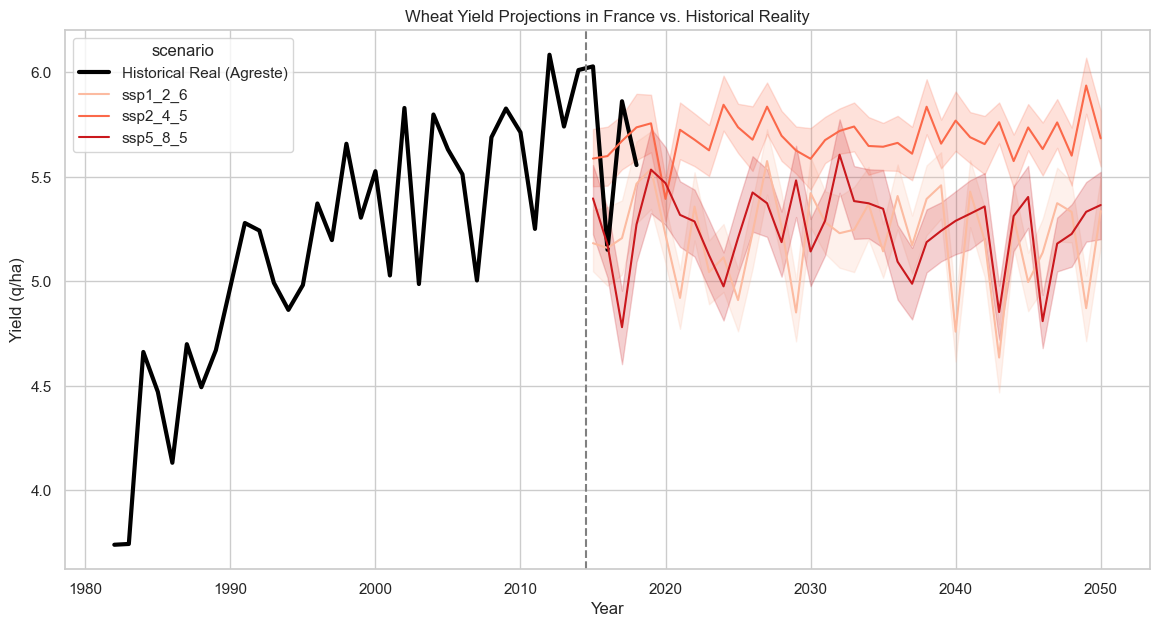

In [143]:
# --- STEP 1: FEATURE ENGINEERING (The Interaction) ---
# We create the 'heat_x_dry' column in both dataframes to capture synergy stress
#df_final['heat_x_dry'] = df_final['nb_jours_chaleur_extreme'] * df_final['nb_jours_sec']
#df_meteo_annuel['heat_x_dry'] = df_meteo_annuel['nb_jours_chaleur_extreme'] * df_meteo_annuel['nb_jours_sec']

# List of features for the model
features = [
    'avg_annual_temp', 
    'total_precipitation', 
    'extreme_heat_days', 
    'dry_days', 
    'frost_days', 
    'rain_variability'
    #'heat_x_dry'
]

# --- STEP 2: TRAINING ON TRUE HISTORICAL DATA (Pre-2015) ---
# We only use years where Weather (observed) and Yield (real) match
# Since climate scenarios start in 2015, we stop training at 2014
df_train_all = df_final[df_final['year'] <= 2014].dropna()

X = df_train_all[features]
y = df_train_all['yield']

# Split 80/20 for internal validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model initialization and training
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Check quality
y_pred_test = rf_model.predict(X_test)
print(f"Validation Score - R²: {r2_score(y_test, y_pred_test):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_test):.2f} q/ha")

# --- STEP 3: PREDICTION ON CLIMATE SCENARIOS (2015 - 2100) ---
# We predict on df_meteo_annuel for all years after the historical cutoff
df_future = df_meteo_annuel[df_meteo_annuel['year'] >= 2015].copy()
df_future['predicted_yield'] = rf_model.predict(df_future[features])

# --- STEP 4: VISUALIZATION ---
plt.figure(figsize=(14, 7))

# Plot REAL historical data (until 2018 based on your dataset)
real_hist = df_yield.groupby('year')['yield'].mean()
plt.plot(real_hist.index, real_hist.values, label='Historical Real (Agreste)', color='black', linewidth=3)

# Plot PROJECTIONS (Scenario-based)
# We group by year and scenario to see the national trend
sns.lineplot(data=df_future, x='year', y='predicted_yield', hue='scenario', palette='Reds')

plt.axvline(x=2014.5, color='gray', linestyle='--', label='Climate Model Start (2015)')
plt.title("Wheat Yield Projections in France vs. Historical Reality")
plt.ylabel("Yield (q/ha)")
plt.xlabel("Year")
plt

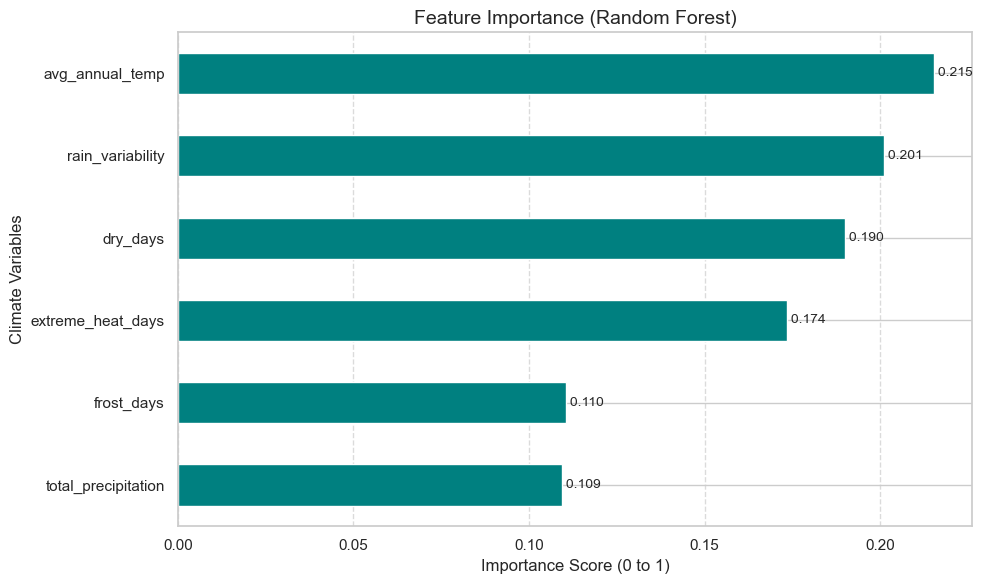

In [144]:
# 1. Get the feature importance scores from your 'rf_model'
importances = rf_model.feature_importances_

# 2. Create a series for plotting (mapped to your feature names)
feat_importances = pd.Series(importances, index=features)

# 3. Plotting
plt.figure(figsize=(10, 6))

# Sorting values to have the most important feature at the top
sorted_importances = feat_importances.sort_values(ascending=True)
sorted_importances.plot(kind='barh', color='teal')

# English labels and title
plt.title('Feature Importance (Random Forest)', fontsize=14)
plt.xlabel('Importance Score (0 to 1)')
plt.ylabel('Climate Variables')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adding the exact values next to the bars for clarity
for index, value in enumerate(sorted_importances):
    plt.text(value, index, f' {value:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning:

The column 2 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning:

The column 3 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning:

The column 4 

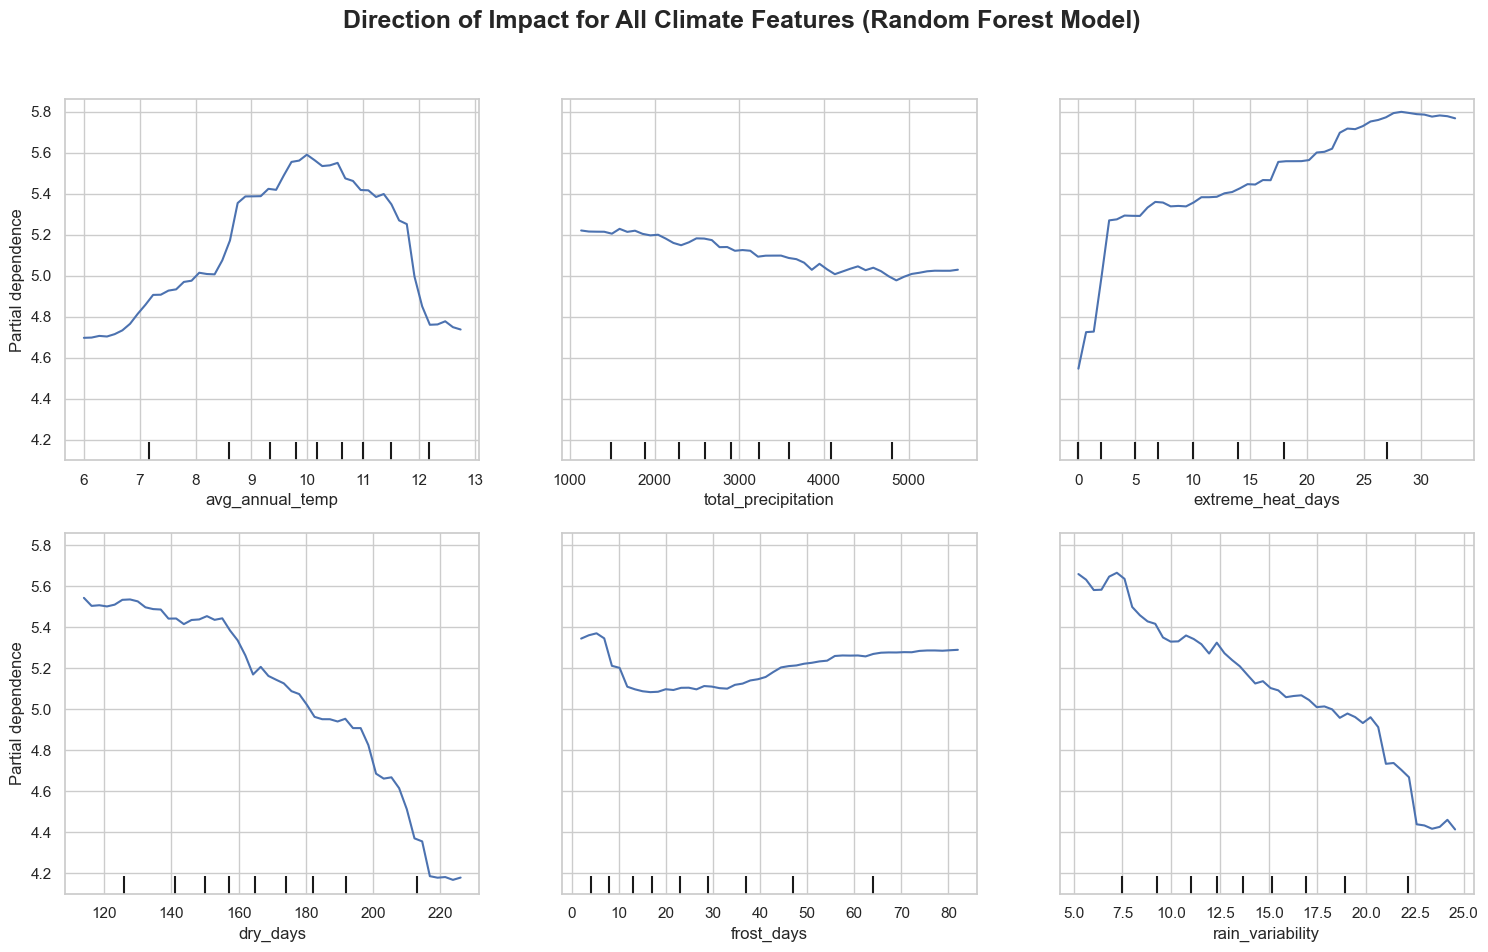

In [145]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# 1. Define all the features used in your model
features = [
    'avg_annual_temp', 
    'total_precipitation', 
    'extreme_heat_days', 
    'dry_days', 
    'frost_days', 
    'rain_variability'
]

# 2. Create a grid of plots (e.g., 2 rows, 3 columns for 6 features)
fig, ax = plt.subplots(figsize=(15, 10))

# 3. Generate the Partial Dependence Plots
# We use X_train.fillna(0) to avoid the "Input contains NaN" error
display = PartialDependenceDisplay.from_estimator(
    rf_model,               # Your trained Random Forest model
    X_train.fillna(0), # Your training data
    features,          # The list of all variables
    ax=ax,
    grid_resolution=50 # Smoothness of the line
)

# 4. English Labels and Formatting
plt.suptitle("Direction of Impact for All Climate Features (Random Forest Model)", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for the title
plt.show()

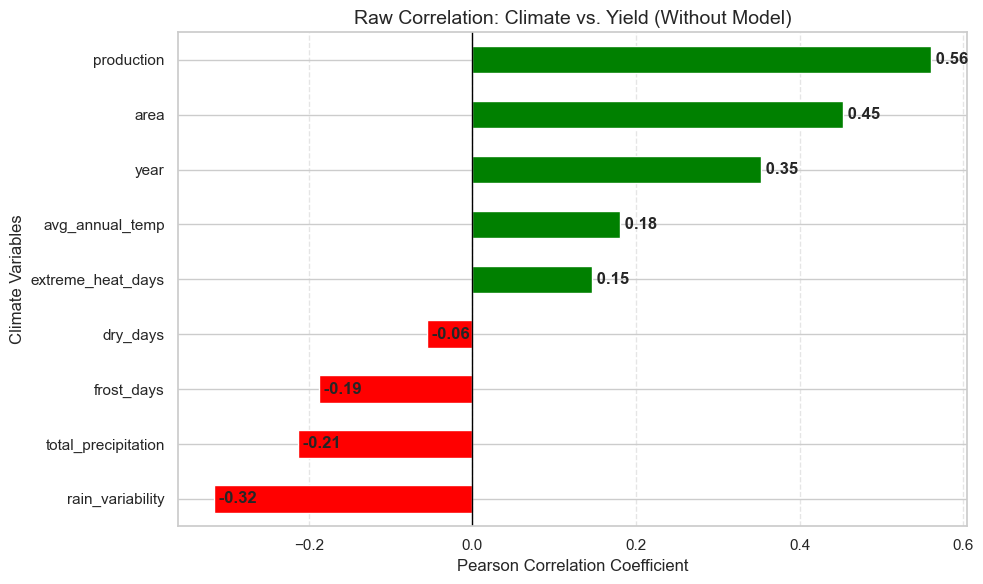

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate the correlation of all variables with yield
# We only use historical data (where actual yield is recorded)
correlations = df_final.corr(numeric_only=True)['yield'].sort_values(ascending=True)

# 2. Remove the 'yield' row (correlation with itself is always 1)
correlations = correlations.drop('yield', errors='ignore')

# 3. Graphical Display
plt.figure(figsize=(10, 6))

# Use colors to distinguish between negative (red) and positive (green) impacts
colors = ['red' if x < 0 else 'green' for x in correlations]
correlations.plot(kind='barh', color=colors)

# Add a vertical line at zero for reference
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)

# English Titles and Labels
plt.title('Raw Correlation: Climate vs. Yield (Without Model)', fontsize=14)
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Climate Variables')
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Display the exact values on the bars for better readability
for i, v in enumerate(correlations):
    plt.text(v, i, f' {v:.2f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

### 1. Allocation Today with France map

In [147]:
import numpy as np
import pandas as pd

hist_area = (
    df_final.groupby("department", as_index=False)["area"]
    .mean()
    .rename(columns={"department": "nom_dep", "area": "area_hist_avg"})
)

df_future_filled = df_future.merge(hist_area, on="nom_dep", how="left")

global_area_mean = df_final["area"].mean()
df_future_filled["area_hist_avg"] = df_future_filled["area_hist_avg"].fillna(global_area_mean)

df_future_filled["area_future"] = df_future_filled["area_hist_avg"]
df_future_filled["production_future_pred"] = (
    df_future_filled["area_future"] * df_future_filled["predicted_yield"]
)

print("Rows in df_future:", len(df_future))
print("Rows in df_future_filled:", len(df_future_filled))
print("Missing area_future:", df_future_filled["area_future"].isna().sum())
print("Missing production_future_pred:", df_future_filled["production_future_pred"].isna().sum())



Rows in df_future: 9612
Rows in df_future_filled: 9612
Missing area_future: 0
Missing production_future_pred: 0


In [148]:
df_future_filled['production_proportion'] = (
    df_future_filled['production_future_pred']
    / df_future_filled.groupby(['scenario','year'])['production_future_pred'].transform('sum')
)


In [149]:
# -----------------------------
# 1) Average across scenarios
# -----------------------------
df_avg = (
    df_future_filled
    .groupby(["nom_dep", "year"], as_index=False)
    .agg({
        "predicted_yield": "mean",
        "area_future": "first",   # same across scenarios
        "area_hist_avg": "first"
    })
)

# -----------------------------
# 2) Recompute production
# -----------------------------
df_avg["production_future_pred"] = (
    df_avg["area_future"] * df_avg["predicted_yield"]
)

# optional rename for clarity
df_avg = df_avg.rename(columns={
    "predicted_yield": "predicted_yield_avg"
})

df_avg.head()


,nom_dep,year,predicted_yield_avg,area_future,area_hist_avg,production_future_pred
0,Ain,2015,5.685449,9869.666667,9869.666667,56113.487467
1,Ain,2016,5.452292,9869.666667,9869.666667,53812.302635
2,Ain,2017,5.552051,9869.666667,9869.666667,54796.890712
3,Ain,2018,5.496670,9869.666667,9869.666667,54250.295742
4,Ain,2019,5.380474,9869.666667,9869.666667,53103.481928


In [150]:
import pandas as pd

# 1) keep historical rows (and non-missing production)
hist = df_final[df_final["scenario"] == "historical"].copy()
hist = hist.dropna(subset=["production", "area", "yield"])

# 2) department-level averages over historical years
dept_summary = (
    hist.groupby("department", as_index=False)
        .agg(
            avg_yield_t_ha=("yield", "mean"),
            avg_area_ha=("area", "mean"),
            avg_volume_tonnes=("production", "mean"),
        )
)

# 3) allocation today = dept avg volume / France avg volume
france_total_volume = dept_summary["avg_volume_tonnes"].sum()
dept_summary["allocation(%)"] = dept_summary["avg_volume_tonnes"] / france_total_volume

# 4) (optional) format nicer
dept_summary = dept_summary.sort_values("allocation(%)", ascending=False)
dept_summary["allocation(%)"] = 100 * dept_summary["allocation(%)"]

# 5) output
dept_summary


,department,avg_yield_t_ha,avg_area_ha,avg_volume_tonnes,allocation(%)
58,Marne,6.958597,86463.937500,603718.128125,5.969208
8,Aube,6.739085,71557.060606,484682.066667,4.792250
68,Pas_de_Calais,7.187806,62298.615385,437275.957692,4.323526
19,Cote_d_Or,5.572052,75779.687500,419697.121875,4.149717
87,Yonne,5.728419,65905.656250,375865.812500,3.716339
...,...,...,...,...,...
48,Landes,4.478946,1014.484848,4136.066667,0.040895
82,Var,3.711358,1143.400000,3869.946667,0.038264
75,Savoie,5.082165,615.741935,3051.906452,0.030175
3,Alpes_Maritimes,3.193572,135.375000,368.643750,0.003645


In [151]:
dept_summary.to_excel("department_allocation_summary.xlsx", index=False)

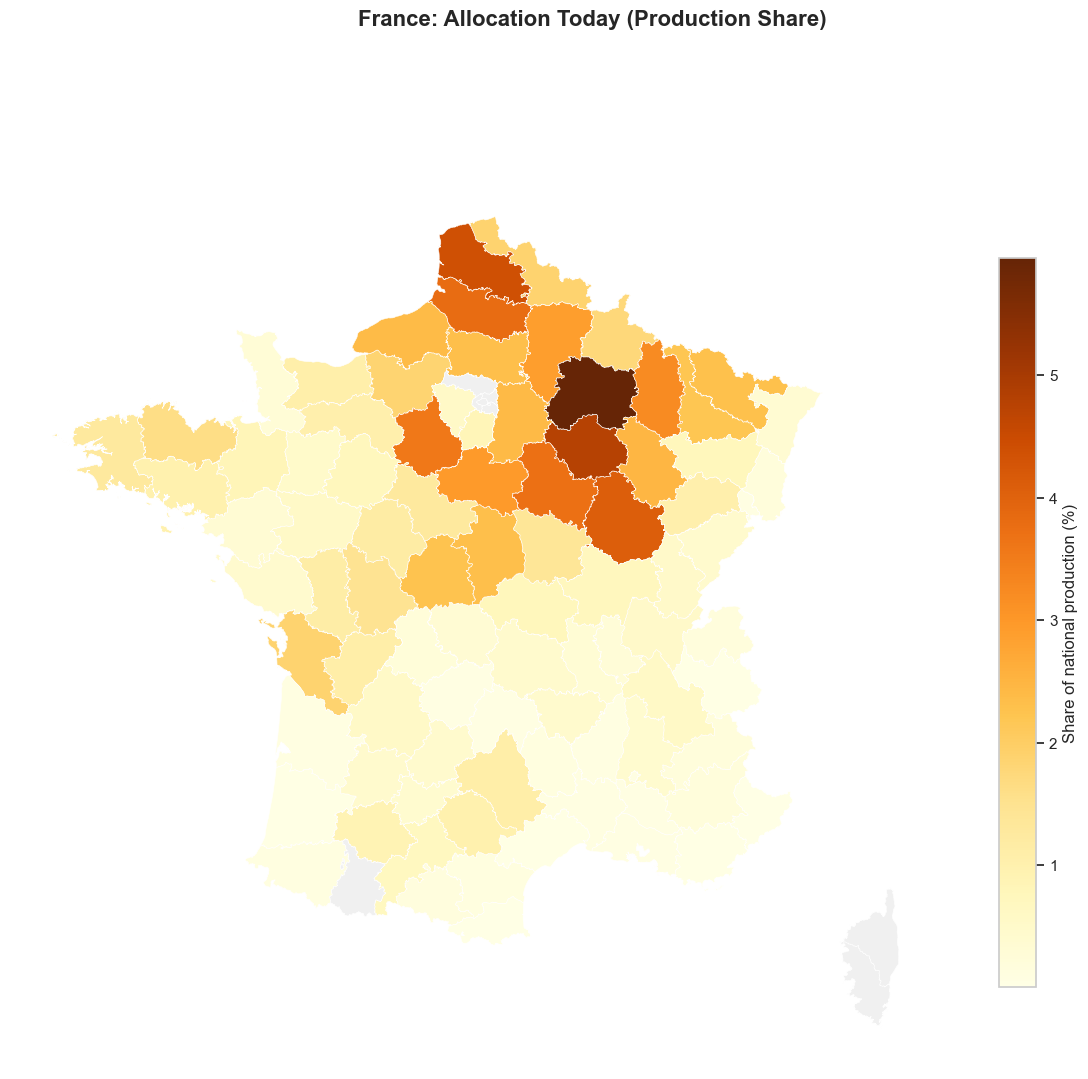

In [152]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import unicodedata

# -------------------------
# 1) Historical allocation today
# -------------------------
hist = df_final[df_final["scenario"] == "historical"].copy()
hist = hist.dropna(subset=["production"])

dept_alloc = (
    hist.groupby("department", as_index=False)
        .agg(avg_volume_tonnes=("production", "mean"))
)

fr_total = dept_alloc["avg_volume_tonnes"].sum()
dept_alloc["allocation_today_pct"] = 100 * dept_alloc["avg_volume_tonnes"] / fr_total

# -------------------------
# 2) Load geo + normalize
# -------------------------
geo = gpd.read_file("france_departments.geojson")

def normalize_name(name):
    nfkd = unicodedata.normalize("NFKD", str(name))
    ascii_name = "".join(c for c in nfkd if not unicodedata.combining(c))
    return ascii_name.replace("-", "_").replace("'", "_").replace(" ", "_")

geo["dept_match"] = geo["nom"].apply(normalize_name)
dept_alloc["dept_match"] = dept_alloc["department"].apply(normalize_name)

geo_a = geo.merge(dept_alloc, on="dept_match", how="left")

# -------------------------
# 3) Plot map
# -------------------------
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
fig.suptitle(
    "France: Allocation Today (Production Share)",
    fontsize=16, fontweight="bold", y=0.96
)

geo_a.plot(
    ax=ax,
    column="allocation_today_pct",
    cmap="YlOrBr",   # ⭐ same palette as original production map
    linewidth=0.4,
    edgecolor="white",
    missing_kwds=dict(color="#f0f0f0", edgecolor="white"),
    legend=True,
    legend_kwds={
        "label": "Share of national production (%)",
        "shrink": 0.7
    }
)

ax.axis("off")
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


### 2. Yield Today and Prediction time series

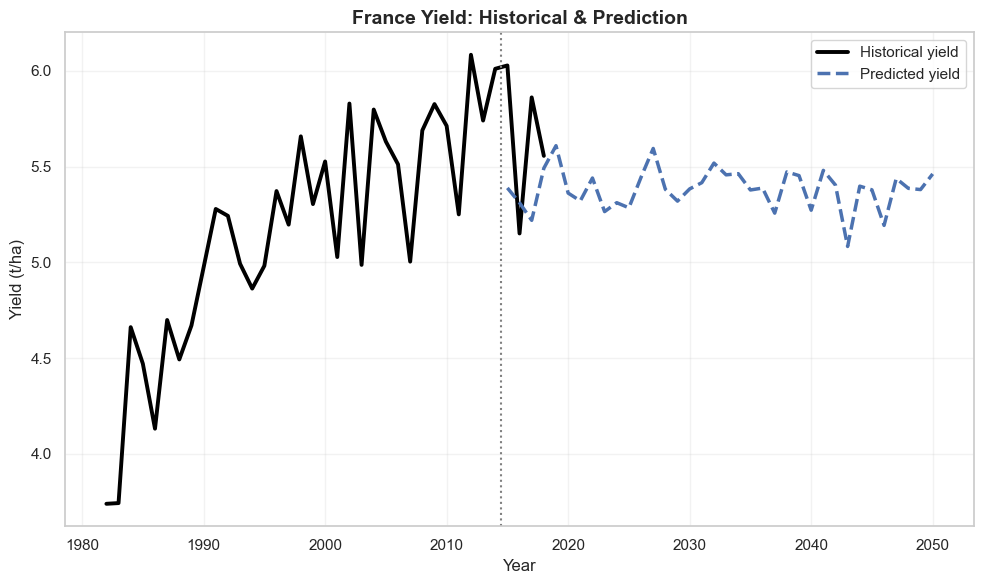

In [153]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1) Historical REAL yields (Agreste)
# -----------------------------
real_hist = (
    df_yield.groupby("year")["yield"]
    .mean()
    .reset_index()
    .rename(columns={"yield": "yield_value"})
)

# -----------------------------
# 2) Future predicted yield (scenario-averaged)
# -----------------------------
future_ts = (
    df_avg.groupby("year")["predicted_yield_avg"]
    .mean()
    .reset_index()
    .rename(columns={"predicted_yield_avg": "yield_value"})
)

# -----------------------------
# 3) Plot
# -----------------------------
plt.figure(figsize=(10,6))

# historical
plt.plot(real_hist["year"], real_hist["yield_value"],
         color="black", linewidth=2.8,
         label="Historical yield")

# predicted
plt.plot(future_ts["year"], future_ts["yield_value"],
         linestyle="--", linewidth=2.5,
         label="Predicted yield")

# transition marker (climate model start)
plt.axvline(2014.5, linestyle=":", color="gray")


plt.title("France Yield: Historical & Prediction",
          fontsize=14, weight="bold")
plt.xlabel("Year")
plt.ylabel("Yield (t/ha)")
plt.legend()
plt.grid(alpha=0.25)

plt.tight_layout()
plt.show()


In [154]:
import pandas as pd

# -----------------------------
# 1) Historical yield (Agreste)
# -----------------------------
real_hist = (
    df_yield.groupby("year")["yield"]
    .mean()
    .reset_index()
    .rename(columns={"yield": "historical_yield"})
)

# -----------------------------
# 2) Predicted yield (scenario-averaged)
# -----------------------------
future_ts = (
    df_avg.groupby("year")["predicted_yield_avg"]
    .mean()
    .reset_index()
    .rename(columns={"predicted_yield_avg": "predicted_yield"})
)

# -----------------------------
# 3) Merge into one table
# -----------------------------
yield_timeseries = pd.merge(
    real_hist,
    future_ts,
    on="year",
    how="outer"
).sort_values("year")

# -----------------------------
# 4) Export to Excel
# -----------------------------
output_path = "france_yield_timeseries.xlsx"

yield_timeseries.to_excel(output_path, index=False)

print("Excel file saved to:", output_path)
yield_timeseries.head()


Excel file saved to: france_yield_timeseries.xlsx


,year,historical_yield,predicted_yield
0,1982,3.739625,NaN
1,1983,3.743384,NaN
2,1984,4.662069,NaN
3,1985,4.471274,NaN
4,1986,4.131973,NaN


### 3. Allocation now vs future

In [155]:
import pandas as pd
import numpy as np

# --- 1) historical avg area by department ---
hist = df_final[df_final["scenario"] == "historical"].copy()

# if your department column is 'department' and area column is 'area'
hist_area = (
    hist.groupby("department", as_index=False)["area"]
        .mean()
)

# rename to match df_avg join key + desired name
hist_area = hist_area.rename(columns={"department": "nom_dep", "area": "area_hist_avg"})

# --- 2) merge into df_avg ---
df_future_prod = df_avg.merge(hist_area, on="nom_dep", how="left")

# --- 3) if merge created suffixes, recover the right column ---
if "area_hist_avg" not in df_future_prod.columns:
    # common suffix cases
    candidates = [c for c in df_future_prod.columns if "area_hist_avg" in c]
    if len(candidates) == 1:
        df_future_prod["area_hist_avg"] = df_future_prod[candidates[0]]
    elif len(candidates) > 1:
        # prefer the merged one (often endswith _y), otherwise take first
        pick = [c for c in candidates if c.endswith("_y")]
        df_future_prod["area_hist_avg"] = df_future_prod[pick[0] if pick else candidates[0]]
    else:
        raise KeyError(
            "Couldn't find area_hist_avg after merge. "
            "Check df_final columns and area column name."
        )

# --- 4) fill missing area with national mean area (fallback) ---
global_area = hist_area["area_hist_avg"].mean()
df_future_prod["area_hist_avg"] = df_future_prod["area_hist_avg"].fillna(global_area)

# --- 5) compute production + allocation (yearly) ---
# df_avg might name yield column either predicted_yield_avg or predicted_yield_mean
yield_col = "predicted_yield_avg" if "predicted_yield_avg" in df_future_prod.columns else "predicted_yield_mean"

df_future_prod["area_future"] = df_future_prod["area_hist_avg"]
df_future_prod["production_future"] = df_future_prod["area_future"] * df_future_prod[yield_col]

df_future_prod["allocation_share"] = (
    df_future_prod["production_future"]
    / df_future_prod.groupby("year")["production_future"].transform("sum")
)
df_future_prod["allocation_pct"] = 100 * df_future_prod["allocation_share"]

df_future_prod


,nom_dep,year,predicted_yield_avg,area_future,area_hist_avg_x,production_future_pred,area_hist_avg_y,area_hist_avg,production_future,allocation_share,allocation_pct
0,Ain,2015,5.685449,10198.181818,9869.666667,56113.487467,10198.181818,10198.181818,57981.243640,0.005952,0.595234
1,Ain,2016,5.452292,10198.181818,9869.666667,53812.302635,10198.181818,10198.181818,55603.463102,0.005650,0.565042
2,Ain,2017,5.552051,10198.181818,9869.666667,54796.890712,10198.181818,10198.181818,56620.823522,0.005834,0.583389
3,Ain,2018,5.496670,10198.181818,9869.666667,54250.295742,10198.181818,10198.181818,56056.034955,0.005469,0.546923
4,Ain,2019,5.380474,10198.181818,9869.666667,53103.481928,10198.181818,10198.181818,54871.049061,0.005263,0.526343
...,...,...,...,...,...,...,...,...,...,...,...
3199,Yvelines,2046,6.067911,8200.696970,9341.511111,56683.460519,8200.696970,8200.696970,49761.101537,0.005292,0.529202
3200,Yvelines,2047,6.519461,8200.696970,9341.511111,60901.617059,8200.696970,8200.696970,53464.123793,0.005439,0.543870
3201,Yvelines,2048,6.200898,8200.696970,9341.511111,57925.758189,8200.696970,8200.696970,50851.685985,0.005150,0.515032
3202,Yvelines,2049,6.153134,8200.696970,9341.511111,57479.566204,8200.696970,8200.696970,50459.984341,0.005195,0.519452


In [156]:
final_alloc = (
    df_future_prod
    .groupby("nom_dep")["allocation_share"]
    .mean()
    .reset_index()
    .rename(columns={"allocation_share": "allocation_final"})
)

final_alloc = final_alloc.sort_values("allocation_final", ascending=False)
final_alloc["allocation_pct"] = 100 * final_alloc["allocation_final"]
final_alloc = final_alloc.drop(columns=["allocation_final"])

In [157]:
# historical production share
hist = df_final[df_final["scenario"] == "historical"].copy()

alloc_today = (
    hist.groupby("department")["production"]
    .mean()
    .reset_index()
    .rename(columns={
        "department": "nom_dep",
        "production": "production_hist_avg"
    })
)

# share of national production
alloc_today["allocation_today_pct"] = (
    100 * alloc_today["production_hist_avg"]
    / alloc_today["production_hist_avg"].sum()
)

alloc_today = alloc_today[["nom_dep", "allocation_today_pct"]]

final_alloc = final_alloc.merge(
    alloc_today,
    on="nom_dep",
    how="left"
)


final_alloc["allocation_change_pct"] = (
    final_alloc["allocation_pct"]
    - final_alloc["allocation_today_pct"]
)



In [158]:
final_alloc = final_alloc.rename(columns={"nom_dep": "department"})
final_alloc = final_alloc[
    ["department",
     "allocation_today_pct",
     "allocation_pct",
     "allocation_change_pct"]
]
final_alloc = final_alloc.round(3)

output_path = "allocation_today_vs_future.xlsx"
final_alloc.to_excel(output_path, index=False)

print("Saved to:", output_path)



Saved to: allocation_today_vs_future.xlsx


Saved: allocation_shift_map_clean.png


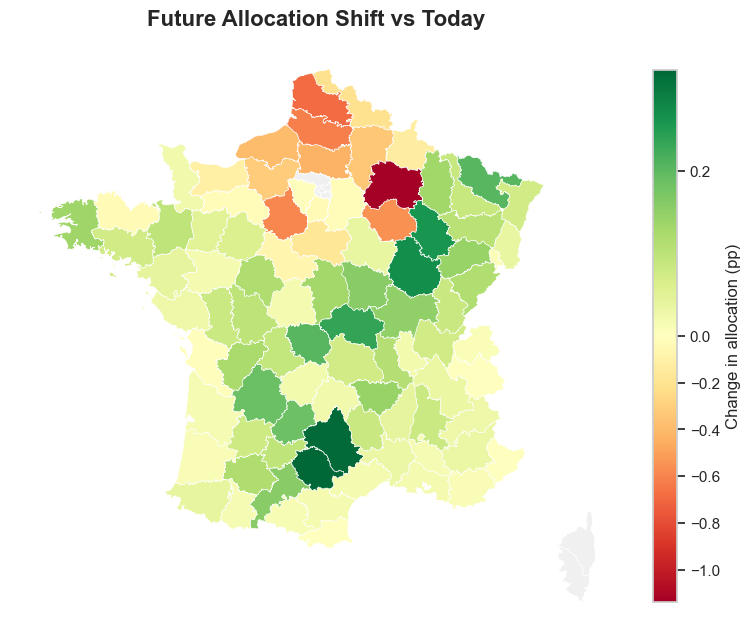

In [159]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import unicodedata

# -------------------------
# 1) Normalize names (robust)
# -------------------------
def normalize_name(name):
    name = str(name).lower().strip()
    name = unicodedata.normalize("NFKD", name)
    name = "".join(c for c in name if not unicodedata.combining(c))
    name = name.replace("-", " ").replace("_", " ").replace("'", " ")
    name = " ".join(name.split())
    return name

# -------------------------
# 2) Load France departments geometry
# -------------------------
geo = gpd.read_file("france_departments.geojson")
geo["dept_match"] = geo["nom"].apply(normalize_name)

# -------------------------
# 3) Prepare final_alloc keys + merge
# final_alloc must contain: department, allocation_change_pct
# -------------------------
final_alloc = final_alloc.copy()
final_alloc["dept_match"] = final_alloc["department"].apply(normalize_name)

geo_change = geo.merge(final_alloc, on="dept_match", how="left")

# -------------------------
# 4) Plot + Save (clean layout)
# -------------------------
col = "allocation_change_pct"
vals = geo_change[col].dropna()

norm = colors.TwoSlopeNorm(vmin=vals.min(), vcenter=0, vmax=vals.max())

fig = plt.figure(figsize=(8, 7))

ax = fig.add_axes([0.05, 0.08, 0.78, 0.84])   # map axis
cax = fig.add_axes([0.86, 0.12, 0.03, 0.76])  # colorbar axis

geo_change.plot(
    ax=ax,
    column=col,
    cmap="RdYlGn",
    norm=norm,
    linewidth=0.4,
    edgecolor="white",
    legend=False,
    missing_kwds=dict(color="#f0f0f0", edgecolor="white")
)

ax.set_title("Future Allocation Shift vs Today", fontsize=16, fontweight="bold", pad=12)
ax.axis("off")

sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm)
sm._A = []
cb = fig.colorbar(sm, cax=cax)
cb.set_label("Change in allocation (pp)", fontsize=12)

out_png = "allocation_shift_map_clean.png"
plt.savefig(out_png, dpi=300, bbox_inches="tight")
print("Saved:", out_png)

plt.show()


Saved: top_allocation_gainers.png


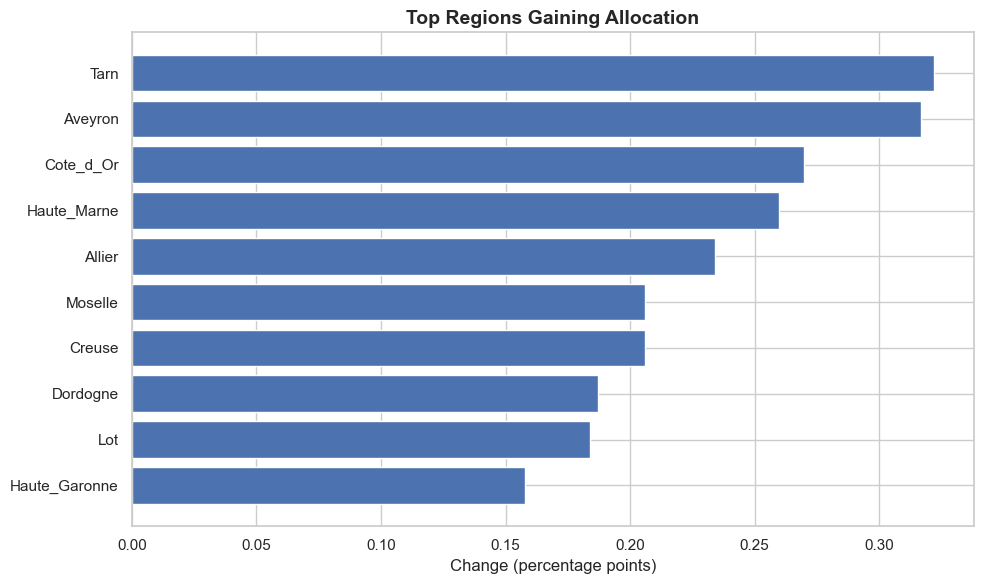

Saved: top_allocation_losers.png


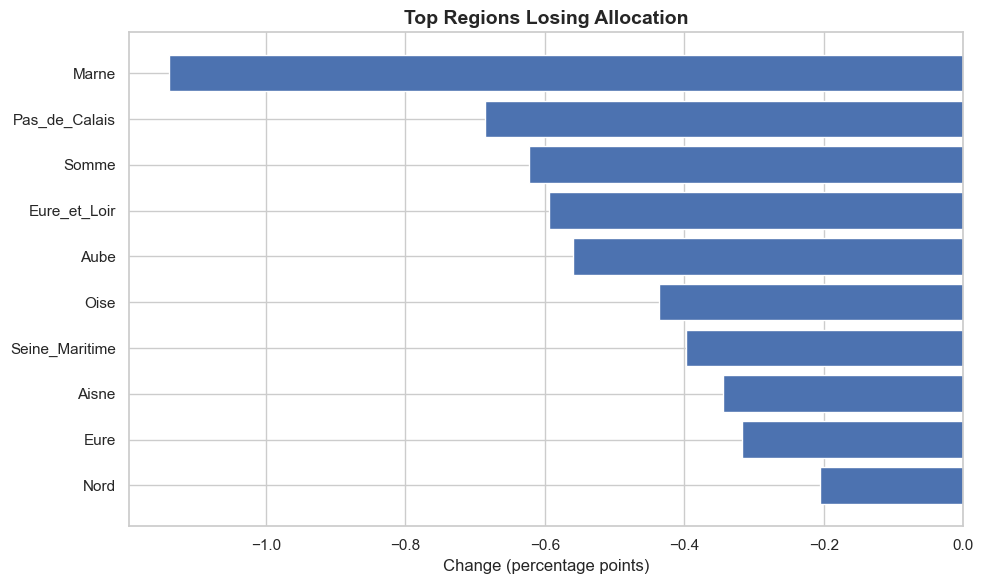

In [160]:
import matplotlib.pyplot as plt

top_gain = final_alloc.nlargest(10, "allocation_change_pct")
top_loss = final_alloc.nsmallest(10, "allocation_change_pct")

# ---------- TOP GAINERS ----------
fig, ax = plt.subplots(figsize=(10,6))

ax.barh(top_gain["department"], top_gain["allocation_change_pct"])
ax.set_title("Top Regions Gaining Allocation", fontsize=14, weight="bold")
ax.set_xlabel("Change (percentage points)")

ax.invert_yaxis()  # biggest on top
plt.tight_layout()

# SAVE
gain_file = "top_allocation_gainers.png"
plt.savefig(gain_file, dpi=300, bbox_inches="tight")
print("Saved:", gain_file)

plt.show()


# ---------- TOP LOSERS ----------
fig, ax = plt.subplots(figsize=(10,6))

ax.barh(top_loss["department"], top_loss["allocation_change_pct"])
ax.set_title("Top Regions Losing Allocation", fontsize=14, weight="bold")
ax.set_xlabel("Change (percentage points)")

ax.invert_yaxis()
plt.tight_layout()

# SAVE
loss_file = "top_allocation_losers.png"
plt.savefig(loss_file, dpi=300, bbox_inches="tight")
print("Saved:", loss_file)

plt.show()


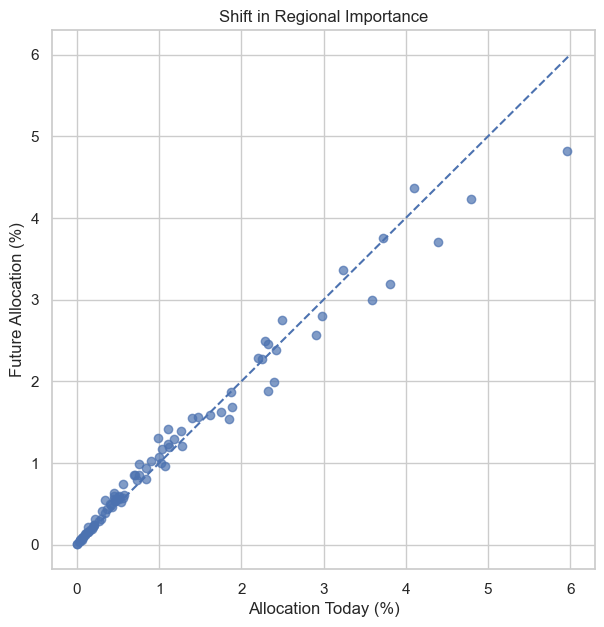

In [161]:
plt.figure(figsize=(7,7))

plt.scatter(
    final_alloc["allocation_today_pct"],
    final_alloc["allocation_pct"],
    alpha=0.7
)

plt.plot([0,6],[0,6], linestyle="--")  # equality line

plt.xlabel("Allocation Today (%)")
plt.ylabel("Future Allocation (%)")
plt.title("Shift in Regional Importance")

plt.show()


In [162]:
import numpy as np
import pandas as pd

# -----------------------------
# 0) Choose planning window
# -----------------------------
YEAR_MIN, YEAR_MAX = 2030, 2050

# df_future_prod has: nom_dep, year, production_future
future_window = df_future_prod[df_future_prod["year"].between(YEAR_MIN, YEAR_MAX)].copy()

# -----------------------------
# 1) Future predicted production per department (avg over window)
# -----------------------------
dept_future_prod = (
    future_window.groupby("nom_dep", as_index=False)["production_future"]
    .mean()
    .rename(columns={"production_future": "predicted_prod_future_tonnes"})
)

# France total future production (avg over window)
fr_total_future = float(dept_future_prod["predicted_prod_future_tonnes"].sum())

# -----------------------------
# 2) Bring in allocations (today vs new)
# final_alloc currently has department column; create nom_dep join version
# -----------------------------
alloc = final_alloc.rename(columns={"department": "nom_dep"}).copy()

# Ensure these are in %
# allocation_today_pct, allocation_pct

# -----------------------------
# 3) Compute production under each allocation strategy
# -----------------------------
alloc["prod_if_keep_today_alloc"] = fr_total_future * (alloc["allocation_today_pct"] / 100.0)
alloc["prod_if_use_new_alloc"] = fr_total_future * (alloc["allocation_pct"] / 100.0)

# -----------------------------
# 4) Compare (growth & difference)
# -----------------------------
alloc["delta_prod_tonnes"] = alloc["prod_if_use_new_alloc"] - alloc["prod_if_keep_today_alloc"]

alloc["growth_%_vs_today_alloc"] = np.where(
    alloc["prod_if_keep_today_alloc"] > 0,
    100 * alloc["delta_prod_tonnes"] / alloc["prod_if_keep_today_alloc"],
    np.nan
)

# -----------------------------
# 5) Merge in the "model-implied" predicted production (for context)
# -----------------------------
out = alloc.merge(dept_future_prod, on="nom_dep", how="left")

# Optional: sort by biggest winners
out = out.sort_values("delta_prod_tonnes", ascending=False)

# Clean columns
out = out[[
    "nom_dep",
    "allocation_today_pct",
    "allocation_pct",
    "predicted_prod_future_tonnes",
    "prod_if_keep_today_alloc",
    "prod_if_use_new_alloc",
    "delta_prod_tonnes",
    "growth_%_vs_today_alloc"
]]

# Nice rounding for business
out = out.round({
    "allocation_today_pct": 3,
    "allocation_pct": 3,
    "predicted_prod_future_tonnes": 0,
    "prod_if_keep_today_alloc": 0,
    "prod_if_use_new_alloc": 0,
    "delta_prod_tonnes": 0,
    "growth_%_vs_today_alloc": 2
})

out.head(15)


,nom_dep,allocation_today_pct,allocation_pct,predicted_prod_future_tonnes,prod_if_keep_today_alloc,prod_if_use_new_alloc,delta_prod_tonnes,growth_%_vs_today_alloc
27,Tarn,0.986,1.307,126012.0,96589.0,128035.0,31445.0,32.56
25,Aveyron,1.103,1.420,138816.0,108051.0,139104.0,31054.0,28.74
1,Cote_d_Or,4.098,4.368,426094.0,401443.0,427892.0,26449.0,6.59
9,Haute_Marne,2.491,2.751,271548.0,244020.0,269490.0,25470.0,10.44
36,Allier,0.756,0.990,96980.0,74058.0,96981.0,22923.0,30.95
11,Moselle,2.292,2.498,249245.0,224526.0,244706.0,20180.0,8.99
53,Creuse,0.345,0.550,54320.0,33796.0,53878.0,20082.0,59.42
44,Dordogne,0.557,0.744,73469.0,54564.0,72883.0,18319.0,33.57
45,Lot,0.449,0.633,61110.0,43984.0,62009.0,18025.0,40.98
41,Haute_Garonne,0.694,0.852,82682.0,67985.0,83462.0,15478.0,22.77


### 4. Allocation delta and flow

In [163]:
import numpy as np
import pandas as pd

# final_alloc must have:
# department, allocation_today_pct, allocation_pct, allocation_change_pct

df = final_alloc.copy()

# 1) change in percentage points (pp)
df["delta_pp"] = df["allocation_pct"] - df["allocation_today_pct"]

# 2) relative change vs today (%)
df["delta_rel_%"] = np.where(
    df["allocation_today_pct"] > 0,
    100 * df["delta_pp"] / df["allocation_today_pct"],
    np.nan
)

# 3) implied volume change (choose a France total)
# Option 1: use historical national production (mean across departments)
hist = df_final[df_final["scenario"] == "historical"].dropna(subset=["production"])
fr_total_tonnes = (hist.groupby("year")["production"].sum()).mean()  # average annual tonnes

df["delta_tonnes"] = (df["delta_pp"] / 100.0) * fr_total_tonnes

# 4) helper to format one sentence per department
def fmt_change(row):
    direction = "increases" if row["delta_pp"] > 0 else "decreases"
    return (
        f"{row['department']}: {direction} by {row['delta_pp']:+.2f} pp "
        f"({row['delta_rel_%']:+.1f}% vs today), ~{row['delta_tonnes']:+,.0f} tonnes"
    )

# Top 10 gainers/losers text
gainers = df.sort_values("delta_pp", ascending=False).head(10)
losers  = df.sort_values("delta_pp", ascending=True).head(10)

print("Top 10 gainers (net):")
for _, r in gainers.iterrows():
    print(" -", fmt_change(r))

print("\nTop 10 losers (net):")
for _, r in losers.iterrows():
    print(" -", fmt_change(r))


Top 10 gainers (net):
 - Tarn: increases by +0.32 pp (+32.6% vs today), ~+32,481 tonnes
 - Aveyron: increases by +0.32 pp (+28.7% vs today), ~+32,076 tonnes
 - Cote_d_Or: increases by +0.27 pp (+6.6% vs today), ~+27,320 tonnes
 - Haute_Marne: increases by +0.26 pp (+10.4% vs today), ~+26,308 tonnes
 - Allier: increases by +0.23 pp (+31.0% vs today), ~+23,678 tonnes
 - Moselle: increases by +0.21 pp (+9.0% vs today), ~+20,844 tonnes
 - Creuse: increases by +0.21 pp (+59.4% vs today), ~+20,743 tonnes
 - Dordogne: increases by +0.19 pp (+33.6% vs today), ~+18,922 tonnes
 - Lot: increases by +0.18 pp (+41.0% vs today), ~+18,618 tonnes
 - Haute_Garonne: increases by +0.16 pp (+22.8% vs today), ~+15,987 tonnes

Top 10 losers (net):
 - Marne: decreases by -1.14 pp (-19.1% vs today), ~-115,251 tonnes
 - Pas_de_Calais: decreases by -0.69 pp (-15.6% vs today), ~-69,515 tonnes
 - Somme: decreases by -0.62 pp (-16.3% vs today), ~-63,039 tonnes
 - Eure_et_Loir: decreases by -0.59 pp (-16.6% vs toda

In [164]:
# Build donors (losers) and receivers (gainers)
donors = df[df["delta_pp"] < 0][["department", "delta_pp"]].copy()
receivers = df[df["delta_pp"] > 0][["department", "delta_pp"]].copy()

donors["need_pp"] = -donors["delta_pp"]         # positive amount to "give"
receivers["take_pp"] = receivers["delta_pp"]    # positive amount to "receive"

donors = donors.sort_values("need_pp", ascending=False).reset_index(drop=True)
receivers = receivers.sort_values("take_pp", ascending=False).reset_index(drop=True)

flows = []
i = j = 0

while i < len(donors) and j < len(receivers):
    give = donors.loc[i, "need_pp"]
    take = receivers.loc[j, "take_pp"]
    amt = min(give, take)

    flows.append({
        "from_department": donors.loc[i, "department"],
        "to_department": receivers.loc[j, "department"],
        "shift_pp": amt,
        "shift_tonnes": (amt/100.0) * fr_total_tonnes
    })

    donors.loc[i, "need_pp"] -= amt
    receivers.loc[j, "take_pp"] -= amt

    if donors.loc[i, "need_pp"] <= 1e-12:
        i += 1
    if receivers.loc[j, "take_pp"] <= 1e-12:
        j += 1

flows_df = pd.DataFrame(flows).sort_values("shift_pp", ascending=False)

# Show biggest illustrative shifts
flows_df


,from_department,to_department,shift_pp,shift_tonnes
0,Marne,Tarn,0.321,32480.862706
1,Marne,Aveyron,0.317,32076.116754
2,Marne,Cote_d_Or,0.270,27320.351809
5,Pas_de_Calais,Allier,0.234,23677.638235
3,Marne,Haute_Marne,0.231,23374.078770
...,...,...,...,...
48,Nord,Ardeche,0.004,404.745953
82,Yvelines,Territoire_de_Belfort,0.002,202.372976
84,Charente_Maritime,Alpes_Maritimes,0.002,202.372976
85,Charente_Maritime,Pyrenees_Orientales,0.002,202.372976


In [165]:
print("Largest illustrative shifts (losers -> gainers):")
for _, r in flows_df.head(15).iterrows():
    print(f" - Shift {r['shift_pp']:.2f} pp (~{r['shift_tonnes']:,.0f} t) "
          f"from {r['from_department']} to {r['to_department']}")


Largest illustrative shifts (losers -> gainers):
 - Shift 0.32 pp (~32,481 t) from Marne to Tarn
 - Shift 0.32 pp (~32,076 t) from Marne to Aveyron
 - Shift 0.27 pp (~27,320 t) from Marne to Cote_d_Or
 - Shift 0.23 pp (~23,678 t) from Pas_de_Calais to Allier
 - Shift 0.23 pp (~23,374 t) from Marne to Haute_Marne
 - Shift 0.21 pp (~20,844 t) from Pas_de_Calais to Moselle
 - Shift 0.21 pp (~20,743 t) from Pas_de_Calais to Creuse
 - Shift 0.18 pp (~18,618 t) from Somme to Lot
 - Shift 0.17 pp (~17,606 t) from Somme to Dordogne
 - Shift 0.16 pp (~15,987 t) from Somme to Haute_Garonne
 - Shift 0.15 pp (~15,178 t) from Eure_et_Loir to Saone_et_Loire
 - Shift 0.14 pp (~14,470 t) from Eure_et_Loir to Haute_Loire
 - Shift 0.14 pp (~14,267 t) from Eure_et_Loir to Haute_Saone
 - Shift 0.13 pp (~13,458 t) from Aube to Meuse
 - Shift 0.13 pp (~13,053 t) from Aube to Cher


In [166]:
import pandas as pd

# Build donors (losers) and receivers (gainers)
donors = df[df["delta_pp"] < 0][["department", "delta_pp"]].copy()
receivers = df[df["delta_pp"] > 0][["department", "delta_pp"]].copy()

donors["need_pp"] = -donors["delta_pp"]          # positive amount to "give"
receivers["take_pp"] = receivers["delta_pp"]     # positive amount to "receive"

donors = donors.sort_values("need_pp", ascending=False).reset_index(drop=True)
receivers = receivers.sort_values("take_pp", ascending=False).reset_index(drop=True)

flows = []
i = j = 0

while i < len(donors) and j < len(receivers):
    give = donors.loc[i, "need_pp"]
    take = receivers.loc[j, "take_pp"]
    amt = min(give, take)  # amt is in percentage points; we label as %

    flows.append({
        "from_department": donors.loc[i, "department"],
        "to_department": receivers.loc[j, "department"],
        "shift_%": amt,  # business label
        "shift_tonnes": (amt / 100.0) * fr_total_tonnes
    })

    donors.loc[i, "need_pp"] -= amt
    receivers.loc[j, "take_pp"] -= amt

    if donors.loc[i, "need_pp"] <= 1e-12:
        i += 1
    if receivers.loc[j, "take_pp"] <= 1e-12:
        j += 1

flows_df = pd.DataFrame(flows).sort_values("shift_%", ascending=False)

# Optional: round for readability
flows_df["shift_%"] = flows_df["shift_%"].round(3)
flows_df["shift_tonnes"] = flows_df["shift_tonnes"].round(0).astype("int64")

# Save to Excel
out_path = "illustrative_allocation_shifts.xlsx"
flows_df.to_excel(out_path, index=False)
print("Saved:", out_path)

flows_df.head(20)


Saved: illustrative_allocation_shifts.xlsx


,from_department,to_department,shift_%,shift_tonnes
0,Marne,Tarn,0.321,32481
1,Marne,Aveyron,0.317,32076
2,Marne,Cote_d_Or,0.270,27320
5,Pas_de_Calais,Allier,0.234,23678
3,Marne,Haute_Marne,0.231,23374
6,Pas_de_Calais,Moselle,0.206,20844
7,Pas_de_Calais,Creuse,0.205,20743
10,Somme,Lot,0.184,18618
9,Somme,Dordogne,0.174,17606
11,Somme,Haute_Garonne,0.158,15987


In [167]:
from plotly import graph_objects as go
import pandas as pd

top_flows = flows_df.head(15)

labels = list(pd.unique(top_flows[['from_department','to_department']].values.ravel()))
label_index = {label:i for i,label in enumerate(labels)}

source = top_flows['from_department'].map(label_index)
target = top_flows['to_department'].map(label_index)
value = top_flows['shift_%']

fig = go.Figure(data=[go.Sankey(
    node=dict(label=labels, pad=15, thickness=15),
    link=dict(source=source, target=target, value=value)
)])

fig.update_layout(title_text="Shift in Production Share Between Departments")

# SAVE
sankey_file = "allocation_shift_sankey.html"
fig.write_html(sankey_file)

print("Saved:", sankey_file)

fig.show()


Saved: allocation_shift_sankey.html


### 5. General France yearly data

In [168]:
import pandas as pd

df = df_yield.copy()

# ensure numeric
df["yield"] = pd.to_numeric(df["yield"], errors="coerce")
df["area"] = pd.to_numeric(df["area"], errors="coerce")
df["production"] = pd.to_numeric(df["production"], errors="coerce")

# remove rows with missing area or production
df = df[df["area"].notna() & df["production"].notna()]

# compute weighted yield
france_yearly = (
    df.groupby("year")
    .apply(lambda x: pd.Series({
        "total_area": x["area"].sum(),
        "total_production": x["production"].sum(),
        "avg_yield": x["production"].sum() / x["area"].sum()  # weighted yield
    }))
    .reset_index()
)

france_yearly.head()


/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_68766/509536820.py:16: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,year,total_area,total_production,avg_yield
0,1982,2387719.0,10035979.1,4.203166
1,1983,2143353.0,8772688.7,4.092974
2,1984,2100128.0,11480652.9,5.466644
3,1985,2255390.0,11426399.6,5.066263
4,1986,2096620.0,10140197.1,4.836450


Saved: france_production_yield_timeseries.png


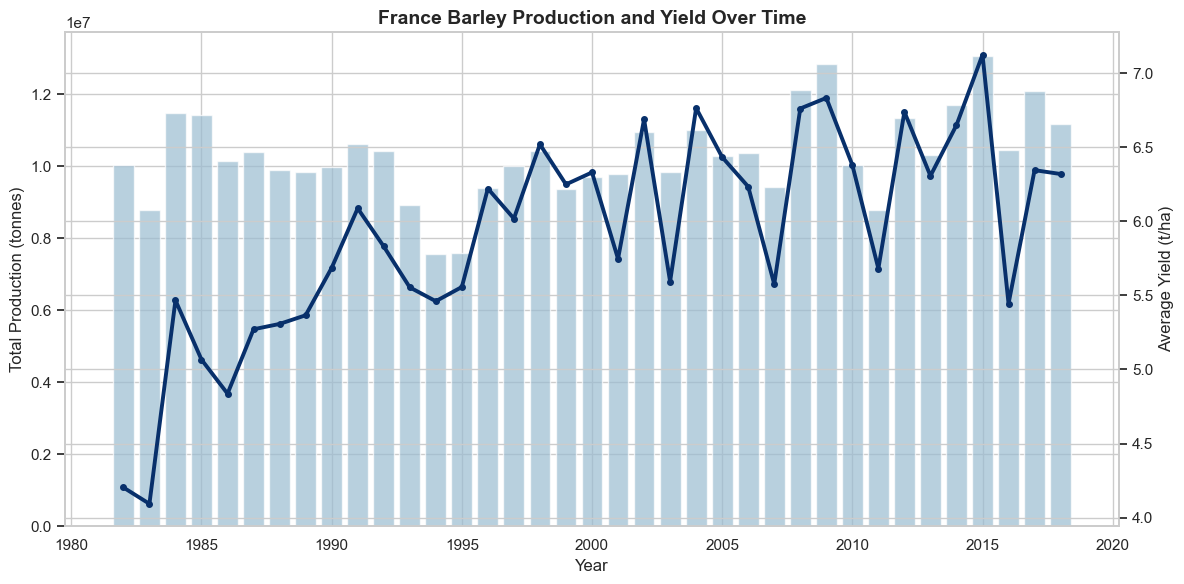

In [169]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12,6))

# --- Production bars (muted blue/grey) ---
ax1.bar(
    france_yearly["year"],
    france_yearly["total_production"],
    color="#9bbcd1",   # soft muted blue
    alpha=0.7
)

ax1.set_xlabel("Year")
ax1.set_ylabel("Total Production (tonnes)")

# --- Yield line (high contrast dark color) ---
ax2 = ax1.twinx()

ax2.plot(
    france_yearly["year"],
    france_yearly["avg_yield"],
    color="#08306b",   # deep navy (high contrast)
    linewidth=2.8,
    marker="o",
    markersize=4
)

ax2.set_ylabel("Average Yield (t/ha)")

plt.title(
    "France Barley Production and Yield Over Time",
    fontsize=14,
    weight="bold"
)

plt.tight_layout()

output_file = "france_production_yield_timeseries.png"

plt.savefig(
    output_file,
    dpi=300,
    bbox_inches="tight"
)

print("Saved:", output_file)
plt.show()


In [170]:
france_yearly.to_excel("france_yearly_production_yield.xlsx", index=False)

In [171]:
!pip install xlsxwriter

46145.45s - pydevd: Sending message related to process being replaced timed-out after 5 seconds

[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_68766/3305788753.py:110: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



✅ Saved high-res chart to: Agricultural_Strategy_Outlook_2030_2050.png


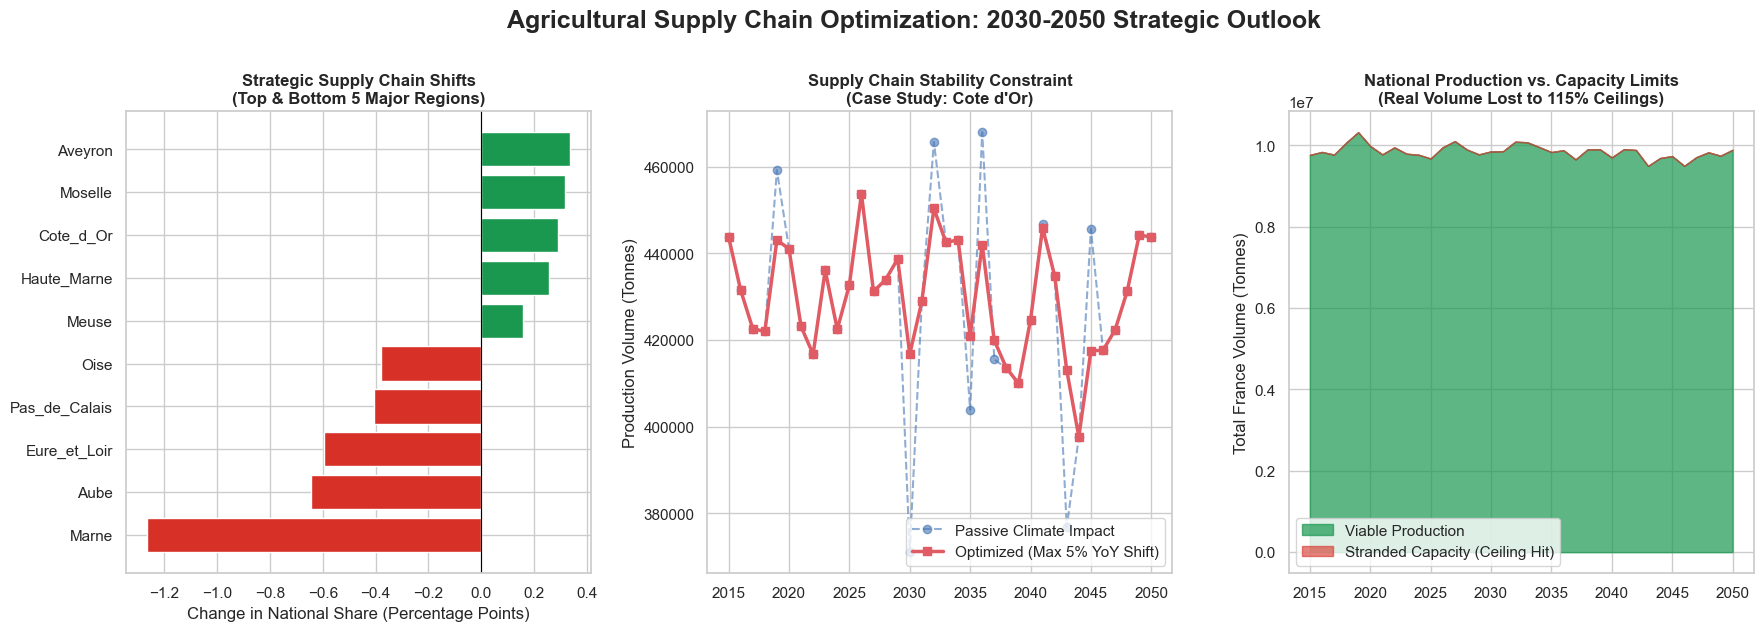

In [172]:

# =====================================================================
# 1. FIXING THE BUSINESS LOGIC (THE "SMART FLOOR")
# =====================================================================
def optimize_allocation_bcg_fixed(predictions, max_capacities, constraints):
    predictions = predictions.sort_values(['nom_dep', 'year'])
    records = []
    
    for dept, group in predictions.groupby('nom_dep'):
        prev_vol = group.iloc[0]['production_future']
        hist_max = max_capacities.get(dept, prev_vol)
        capacity_ceiling = hist_max * constraints['max_capacity_multiplier']
        
        # THE FIX: Don't force a 10k floor on a department that historically maxed out under 10k.
        smart_floor = min(constraints['min_vol'], hist_max)
        
        for idx, row in group.iterrows():
            raw_vol = row['production_future']
            year = row['year']
            
            constrained_vol = raw_vol
            unallocated_vol = 0
            
            # 1. Apply Capacity Ceiling FIRST (Now calculates REAL stranded volume)
            if constrained_vol > capacity_ceiling:
                unallocated_vol = constrained_vol - capacity_ceiling
                constrained_vol = capacity_ceiling
                
            # 2. Apply Smart Floor
            constrained_vol = max(constrained_vol, smart_floor)
            
            # 3. Apply Stability / Max YoY Shift
            if year > group.iloc[0]['year']:
                max_delta = prev_vol * constraints['max_shift_pct']
                if (constrained_vol - prev_vol) > max_delta:
                    constrained_vol = prev_vol + max_delta
                elif (constrained_vol - prev_vol) < -max_delta:
                    constrained_vol = prev_vol - max_delta
                    
            prev_vol = constrained_vol
            yld_col = 'predicted_yield_avg' if 'predicted_yield_avg' in row else 'predicted_yield_mean'
            
            records.append({
                'year': year,
                'department': dept,
                'production_raw': raw_vol,
                'production': constrained_vol,
                'unallocated_volume_tonnes': unallocated_vol
            })
            
    return pd.DataFrame(records)

# Rerun optimization with fixed logic
df_future_opt_fixed = optimize_allocation_bcg_fixed(df_future_prod, dept_max_capacity, bcg_constraints)

# Recalculate National Totals for the plot
france_master_ts_fixed = df_future_opt_fixed.groupby('year').agg(
    total_volume_tonnes=('production', 'sum'),
    total_unallocated_tonnes=('unallocated_volume_tonnes', 'sum')
).reset_index()

# Recalculate Shifts for Plotting (2030-2050 vs Today)
future_window = df_future_opt_fixed[df_future_opt_fixed['year'].between(2030, 2050)]
dept_future_alloc = future_window.groupby('department')['production'].mean().reset_index()
dept_future_alloc['allocation_pct'] = (dept_future_alloc['production'] / dept_future_alloc['production'].sum()) * 100

alloc_today_df = hist_ts.groupby('department')['production'].mean().reset_index()
alloc_today_df['allocation_today_pct'] = (alloc_today_df['production'] / alloc_today_df['production'].sum()) * 100

shift_df = dept_future_alloc.merge(alloc_today_df, on='department', how='left')
shift_df['allocation_change_pct'] = shift_df['allocation_pct'] - shift_df['allocation_today_pct']

# =====================================================================
# 2. BCG-READY PRESENTATION PLOTS
# =====================================================================
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(21, 6), gridspec_kw={'wspace': 0.25})

# --- PLOT 1: Strategic Shifts (Major Departments Only) ---
# Filter out tiny departments (< 1% share today) to focus on material business impact
major_depts = shift_df[shift_df['allocation_today_pct'] >= 1.0].copy()
top_gain = major_depts.nlargest(5, 'allocation_change_pct')
top_loss = major_depts.nsmallest(5, 'allocation_change_pct')
plot_df = pd.concat([top_gain, top_loss]).sort_values('allocation_change_pct', ascending=True)

colors = ['#d73027' if x < 0 else '#1a9850' for x in plot_df['allocation_change_pct']]
axes[0].barh(plot_df['department'], plot_df['allocation_change_pct'], color=colors)
axes[0].set_title("Strategic Supply Chain Shifts\n(Top & Bottom 5 Major Regions)", fontweight='bold')
axes[0].set_xlabel("Change in National Share (Percentage Points)")
axes[0].axvline(0, color='black', linewidth=0.8)

# --- PLOT 2: Volatility Mitigation (Cote d'Or) ---
cote_dor = df_future_opt_fixed[df_future_opt_fixed['department'] == 'Cote_d_Or']
axes[1].plot(cote_dor['year'], cote_dor['production_raw'], linestyle="--", marker="o", color="#4575b4", alpha=0.6, label="Passive Climate Impact")
axes[1].plot(cote_dor['year'], cote_dor['production'], linewidth=2.5, marker="s", color="#e15b64", label="Optimized (Max 5% YoY Shift)")
axes[1].set_title("Supply Chain Stability Constraint\n(Case Study: Cote d'Or)", fontweight='bold')
axes[1].set_ylabel("Production Volume (Tonnes)")
axes[1].legend(loc="lower right", frameon=True)

# --- PLOT 3: Real Stranded Capacity ---
axes[2].fill_between(france_master_ts_fixed['year'], 0, france_master_ts_fixed['total_volume_tonnes'], color="#1a9850", alpha=0.7, label="Viable Production")
axes[2].fill_between(france_master_ts_fixed['year'], 
                     france_master_ts_fixed['total_volume_tonnes'], 
                     france_master_ts_fixed['total_volume_tonnes'] + france_master_ts_fixed['total_unallocated_tonnes'], 
                     color="#d73027", alpha=0.6, label="Stranded Capacity (Ceiling Hit)")
axes[2].set_title("National Production vs. Capacity Limits\n(Real Volume Lost to 115% Ceilings)", fontweight='bold')
axes[2].set_ylabel("Total France Volume (Tonnes)")
axes[2].legend(loc="lower left", frameon=True)

plt.suptitle("Agricultural Supply Chain Optimization: 2030-2050 Strategic Outlook", fontsize=18, fontweight='bold', y=1.05)
plt.tight_layout()
plt.savefig('Agricultural_Strategy_Outlook_2030_2050.png', dpi=300, bbox_inches='tight')
print("✅ Saved high-res chart to: Agricultural_Strategy_Outlook_2030_2050.png")
plt.show()

In [173]:
# =====================================================================
# 3. EXPORT: CORRECTED DEPARTMENTAL TIME SERIES (LINKED TO FIXED LOGIC)
# =====================================================================
print("\nGenering Final CSV Export...")

# 1. Prepare Future Data (USING THE FIXED DATAFRAME)
# This uses the 'fixed' dataframe from the previous cell
future_export = df_future_opt_fixed[['year', 'department', 'production']].copy()
future_export.rename(columns={'production': 'volume_tonnes'}, inplace=True)
future_export['type'] = 'Forecast (Optimized)'

# 2. Prepare Historical Data (Matches structure)
hist_export = hist_ts[['year', 'department', 'production']].copy()
hist_export.rename(columns={'production': 'volume_tonnes'}, inplace=True)
hist_export['type'] = 'Historical (Actual)'

# 3. Combine & Sort
full_ts = pd.concat([hist_export, future_export], ignore_index=True)
full_ts = full_ts.sort_values(['department', 'year'])

# 4. Pivot for Finance (Rows = Depts, Columns = Years)
# Finance models love years as columns
pivot_ts = full_ts.pivot_table(index='department', columns='year', values='volume_tonnes')

# 5. Export
filename = "Department_Volume_TimeSeries_1982_2050_FINAL.csv"
pivot_ts.to_csv(filename)

print(f"✅ READY TO SEND: {filename}")
print(f"Contains volume for {len(pivot_ts)} departments x {len(pivot_ts.columns)} years.")
print("\nPreview of CSV Content:")
print(pivot_ts.iloc[:5, -5:]) # Show last 5 years for first 5 depts


Genering Final CSV Export...
✅ READY TO SEND: Department_Volume_TimeSeries_1982_2050_FINAL.csv
Contains volume for 94 departments x 69 years.

Preview of CSV Content:
year                              2046           2047           2048  \
department                                                             
Ain                       57813.811930   58004.816397   60905.057217   
Aisne                    236087.253143  247891.615801  251697.579399   
Allier                    92056.025368   96658.826637   92804.554337   
Alpes_Maritimes            1000.000000    1000.000000    1000.000000   
Alpes_de_Haute_Provence   23714.720815   23684.700445   22500.465422   

year                              2049           2050  
department                                             
Ain                       59333.487875   56488.274694  
Aisne                    248492.251065  260916.863618  
Allier                    94842.411630   94746.073071  
Alpes_Maritimes            1000.000000    1000.

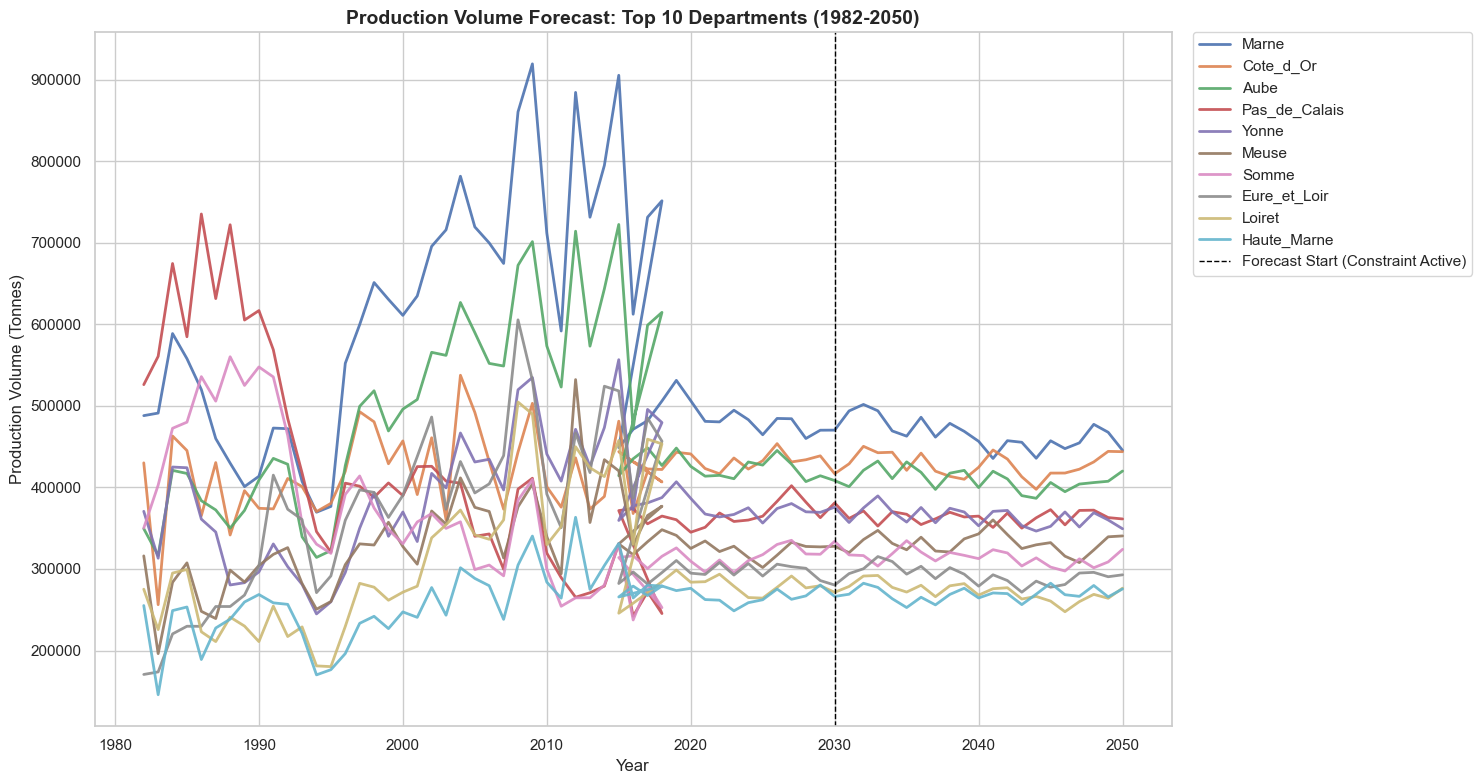

Plot saved as: departmental_volume_forecast_fixed.png


In [174]:
# ==========================================
# PLOT: Departmental Volume Time Series (Key Players) - [FIXED]
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 8))
sns.set_theme(style="whitegrid")

# Select Top 10 Departments by total 2050 volume (Using the FIXED optimization)
top_10 = df_future_opt_fixed[df_future_opt_fixed['year'] == 2050].nlargest(10, 'production')['department'].tolist()

# Plot Top 10 with colors
for dept in top_10:
    # Get Historical Data
    hist_d = df_yield[df_yield['department'] == dept].sort_values('year')
    # Get Future Optimized (FIXED)
    fut_d = df_future_opt_fixed[df_future_opt_fixed['department'] == dept].sort_values('year')
    
    # Plot as a continuous line
    # Combine lists for plotting
    years = list(hist_d['year']) + list(fut_d['year'])
    vols = list(hist_d['production']) + list(fut_d['production'])
    
    plt.plot(years, vols, label=dept, linewidth=2, alpha=0.9)

# Add separation line for forecast
plt.axvline(x=2030, color='black', linestyle='--', linewidth=1, label='Forecast Start (Constraint Active)')

plt.title('Production Volume Forecast: Top 10 Departments (1982-2050)', fontsize=14, fontweight='bold')
plt.ylabel('Production Volume (Tonnes)')
plt.xlabel('Year')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()

plt.savefig('departmental_volume_forecast_fixed.png', dpi=300)
plt.show()

print("Plot saved as: departmental_volume_forecast_fixed.png")